In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing and file IO
import matplotlib.pyplot as plt # visualize images
from scipy.stats import mode

# evaluate label propagation on the semi-supervised learning dataset from numpy import concatenate

import seaborn as sns
from tensorflow.python.client import device_lib 
import tensorflow as tf
from tensorflow.keras import layers,models

from sklearn.model_selection import train_test_split
from keras.layers import concatenate

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix

2022-08-19 12:10:28.495157: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


### Train Data 시각화 함수

In [2]:
# Not included in the problem slides.
def Data_visualization(Y_train):
    ratios = np.sum(Y_train, axis=0) / Y_train.shape[0] 
    labels = ['Barren Land', 'Trees', 'Grassland', 'Other']

    for l, v in zip(labels, ratios * 100): 
        print('{}: {:.1f}%'.format(l, v))

    cmap = plt.get_cmap('Pastel1')
    colors = [cmap(i) for i in np.linspace(0, 1, 8)]

    plt.pie(ratios, labels = labels, autopct='%.1f%%', shadow=True, colors=colors) 
    plt.show()
    return ratios

### 평가 histogram 함수

In [3]:
def visulization_by_epochs(res_y_vaccuracy, res_y_accuracy):
    print(res_y_vaccuracy.index(max(res_y_vaccuracy)) + 1, ' ',max(res_y_vaccuracy)) 

    res_x_len = np.arange(len(res_y_accuracy))

    plt.plot(res_x_len, res_y_vaccuracy, marker='.', c='red', label="Validation-set Los")
    plt.plot(res_x_len, res_y_accuracy, marker='.', c='blue', label="Train-set Loss")

    plt.legend(loc='upper right') 
    plt.grid() 
    plt.xlabel('epoch') 
    plt.ylabel('accuracy') 
    plt.show()

### Confusion Matrix 함수

In [4]:
#confusion matrix를 확인하고 싶었지만, 해당 값이 분류모델로 되어있는 것이 아닌 상대적 확률로써 존재
def draw_confusionmatrix(y_predict, y_test):
    new_y_predict = []

    for y in y_predict:
        best_y = np.where(y == max(y))
        new_array = np.array([0, 0, 0, 0])
        new_array[best_y] = 1
        new_y_predict.append(new_array)

    new_y_predict = np.array(new_y_predict)


    cf = confusion_matrix(new_y_predict.argmax(axis = 1), y_test.argmax(axis = 1))
    f = sns.heatmap(cf, annot=True, fmt='d')

### 기초 통계값 출력 함수

In [5]:
def print_stat(y_res_add):
    res_y_max = []

    for y in y_res_add:
        res_y_max.append(float(max(y)))

    print('최빈값: ', mode(res_y_max))
    print('평균: ', np.median(res_y_max))
    print('분산: ', np.var(res_y_max))
    print('표준편차: ', np.std(res_y_max))
    print('사분위1: ', np.quantile(res_y_max, 0.25))
    print('사분위2(중앙값): ', np.quantile(res_y_max, 0.5))
    print('사분위3: ', np.quantile(res_y_max, 0.75))

    hist, edges = np.histogram(res_y_max, 100)
    sns.distplot(res_y_max, bins = 10, kde = False)

    count_under = 0
    count_upper = 0
    for y in res_y_max:
        if y < 0.9:
            count_under += 1
        else:
            count_upper += 1

    print('0.9 이하 개수: ', count_under)
    print('0.9 이상 개수: ', count_upper)


### Data 불러오기

In [6]:
#Train Data 불러오기
X_train_path = 'data/X_train.csv' 
Y_train_path = 'data/y_train.csv'

X_train_df = pd.read_csv(X_train_path, header=None)
Y_train_df = pd.read_csv(Y_train_path, header=None)

X_train = X_train_df.values / 255
Y_train = Y_train_df.values

n_images = X_train.shape[0]
shape = [n_images, 28, 28, 4]
X_train_img = X_train.reshape(shape) 
print(X_train_img.shape) 
print('Train_img') 
print(Y_train.shape)


#ADD Data 불러오기
X_add_path = 'data/X_add.csv' 
X_add_df = pd.read_csv(X_add_path, header=None) 

X_add = X_add_df.values / 255
n_add_images = X_add.shape[0]
add_shape = [n_add_images, 28, 28, 4]
X_add_img = X_add.reshape(add_shape)
print('ADD_img')
print(X_add_img.shape)

#Test Data 불러오기
X_test_path = 'data/X_test.csv' 
Y_test_path = 'data/y_test.csv'

X_test_df = pd.read_csv(X_test_path, header=None)
Y_test_df = pd.read_csv(Y_test_path, header=None)

X_test = X_test_df.values / 255 
Y_test = Y_test_df.values 

n_test_images = X_test.shape[0]
test_shape = [n_test_images, 28, 28, 4] 
print('Test_img')
X_test_img = X_test.reshape(test_shape)
print(X_test_img.shape)
print(Y_test.shape)

(2000, 28, 28, 4)
Train_img
(2000, 4)
ADD_img
(10000, 28, 28, 4)
Test_img
(10000, 28, 28, 4)
(10000, 4)


### Transfer Model 호출

In [7]:
ResNet50_MODEL = tf.keras.applications.ResNet50(input_shape = (32,32,3), 
                                                include_top = False,
                                                weights = 'imagenet')

2022-08-19 12:10:36.823199: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-19 12:10:36.836591: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-19 12:10:36.903480: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-19 12:10:36.904136: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-08-19 12:10:36.904184: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-08-19 12:10:36.970300: I tensorflow/stream_executor/platform/default/dso_loade

In [8]:
VGG16_model = tf.keras.applications.vgg16.VGG16(input_shape = (32,32,3), 
                                                include_top = False,
                                                weights = 'imagenet')

### Augmentation

In [9]:
from keras.preprocessing.image import ImageDataGenerator
datagen2 = ImageDataGenerator(
    rotation_range=15, #15도 회전
    horizontal_flip = True, #상하반전
    vertical_flip = True) # 좌우반전

datagen3 = ImageDataGenerator(
    #rotation_range=15, #15도 회전
    horizontal_flip = True, #상하반전
    vertical_flip = False) # 좌우반전

datagen4 = ImageDataGenerator(
    #rotation_range=15, #15도 회전
    horizontal_flip = False, #상하반전
    vertical_flip = True) # 좌우반전


In [10]:
#1번 솔루션
x_squeeze_img_v1_train = np.squeeze(X_train_img[:, :, :, 0:3]) 
x_squeeze_img_v1_add = np.squeeze(X_add_img[:, :, :, 0:3]) 


#2번 솔루션
x_squeeze_img_v2_train = np.concatenate((np.squeeze(X_train_img[:, :, :, 0:2]), np.squeeze(X_train_img[:, :, :, 3]).reshape(2000, 28, 28, 1)), axis = 3)
x_squeeze_img_v2_add = np.concatenate((np.squeeze(X_add_img[:, :, :, 0:2]), np.squeeze(X_add_img[:, :, :, 3]).reshape(10000, 28, 28, 1)), axis = 3)

#3번 솔루션
x_squeeze_img_v3_train = np.concatenate((np.squeeze(X_train_img[:, :, :, 0]).reshape(2000, 28, 28, 1), np.squeeze(X_train_img[:, :, :, 2:4])), axis = 3)
x_squeeze_img_v3_add = np.concatenate((np.squeeze(X_add_img[:, :, :, 0]).reshape(10000, 28, 28, 1), np.squeeze(X_add_img[:, :, :, 2:4])), axis = 3)


#4번 솔루션
x_squeeze_img_v4_train = np.squeeze(X_train_img[:, :, :, 1:4])
x_squeeze_img_v4_add = np.squeeze(X_add_img[:, :, :, 1:4])

In [11]:
train_data_2 = datagen2.flow(x=x_squeeze_img_v2_train, y=Y_train, batch_size = 2000)
train_data_3 = datagen3.flow(x=x_squeeze_img_v3_train, y=Y_train, batch_size = 2000)
train_data_4 = datagen4.flow(x=x_squeeze_img_v4_train, y=Y_train, batch_size = 2000)

train_X_2, train_y_2 = train_data_2.next()
train_X_3, train_y_3 = train_data_3.next()
train_X_4, train_y_4 = train_data_4.next()

add_data_2 = datagen2.flow(x=x_squeeze_img_v2_add, batch_size = 10000)
add_data_3 = datagen3.flow(x=x_squeeze_img_v3_add, batch_size = 10000)
add_data_4 = datagen4.flow(x=x_squeeze_img_v4_add, batch_size = 10000)

add_X_2 = add_data_2.next()
add_X_3 = add_data_3.next()
add_X_4 = add_data_4.next()

In [12]:
total_train_x = np.concatenate((x_squeeze_img_v1_train, train_X_2, train_X_3, train_X_4), axis = 0)
total_train_y = np.concatenate((Y_train, train_y_2, train_y_3, train_y_4), axis = 0)
print('total_train_x', total_train_x.shape)
print('total_train_y', total_train_y.shape)

total_add_x = np.concatenate((x_squeeze_img_v1_add, add_X_2, add_X_3, add_X_4), axis = 0)
print('total_add_x', total_add_x.shape)

total_train_x (8000, 28, 28, 3)
total_train_y (8000, 4)
total_add_x (40000, 28, 28, 3)
total_test_x (40000, 28, 28, 3)
total_test_y (40000, 4)


total_train_x:  8000
total_train_y:  8000
Barren Land: 12.5%
Trees: 12.5%
Grassland: 25.0%
Other: 50.0%


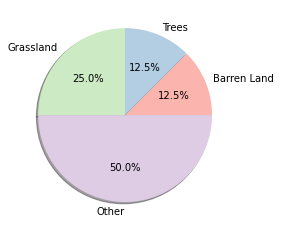

array([0.125, 0.125, 0.25 , 0.5  ])

In [13]:
print('total_train_x: ',len(total_train_x))
print('total_train_y: ',len(total_train_y))
Data_visualization(total_train_y)

### Pseudo Labeling

##### Base Model train

In [14]:
x_train, x_test, y_train, y_test = train_test_split(total_train_x, total_train_y, test_size = 0.2)

In [15]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)

In [16]:
img_shape = (x_squeeze_img_v1_train[1], x_squeeze_img_v1_train[2], x_squeeze_img_v1_train[3])
model_res = models.Sequential()
# For training from scratch change kernel_initializer to e.g.'VarianceScaling'
model_res.add(layers.ZeroPadding2D(padding = (2,2), input_shape = (28, 28, 3)))
model_res.add(ResNet50_MODEL)
model_res.add(layers.Flatten())
model_res.add(layers.Dense(256, activation='relu'))
model_res.add(layers.Dense(128, activation='relu'))
model_res.add(layers.Dense(4, activation='softmax'))

model_res.compile(optimizer='Adam',
                     loss='categorical_crossentropy',
                     metrics=['acc'])

model_res.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 32, 32, 3)         0         
_________________________________________________________________
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 516       
Total params: 24,145,668
Trainable params: 24,092,548
Non-trainable params: 53,120
_______________________________________

In [17]:
img_shape = (X_train_img[1], X_train_img[2], X_train_img[3])
model_vgg = models.Sequential()
# For training from scratch change kernel_initializer to e.g.'VarianceScaling'
model_vgg.add(layers.ZeroPadding2D(padding = (2,2), input_shape = (28, 28 ,3)))
model_vgg.add(VGG16_model)
model_vgg.add(layers.Flatten())
model_vgg.add(layers.Dense(256, activation='relu'))
model_vgg.add(layers.Dense(128, activation='relu'))
model_vgg.add(layers.Dense(4, activation='softmax'))

model_vgg.compile(optimizer='Adam',
                     loss='categorical_crossentropy',
                     metrics=['acc'])

model_vgg.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 32, 32, 3)         0         
_________________________________________________________________
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 516       
Total params: 14,879,428
Trainable params: 14,879,428
Non-trainable params: 0
__________________________________________

In [18]:
model_base=models.Sequential()
model_base.add( layers.Conv2D(32,(5,5),activation='relu',input_shape=(28,28,3)))
model_base.add(layers.MaxPool2D((2,2)))
model_base.add(layers.Conv2D(64,(2,2),activation='relu',padding='same'))
model_base.add(layers.MaxPooling2D((2, 2)))
model_base.add(layers.Dropout(0.25))
model_base.add(layers.Flatten())

model_base.add(layers.Dense(128, activation='relu'))
model_base.add( layers.Dense(4, activation='softmax'))
model_base.summary()
model_base.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['acc'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 32)        2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 64)        8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)              

In [19]:
history_res = model_res.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val))

Epoch 1/50


2022-08-19 12:10:50.889863: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-08-19 12:10:50.898618: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2299995000 Hz
2022-08-19 12:10:54.894877: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-19 12:10:55.527430: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-08-19 12:10:57.757769: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-08-19 12:10:57.825290: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


160/160 [==============================] - 47s 42ms/step - loss: 0.8507 - acc: 0.7248 - val_loss: 1.4667 - val_acc: 0.2508
Epoch 2/50
160/160 [==============================] - 6s 34ms/step - loss: 0.4434 - acc: 0.8439 - val_loss: 1.4977 - val_acc: 0.2508
Epoch 3/50
160/160 [==============================] - 6s 35ms/step - loss: 0.3130 - acc: 0.8944 - val_loss: 1.3462 - val_acc: 0.4852
Epoch 4/50
160/160 [==============================] - 6s 35ms/step - loss: 0.2766 - acc: 0.9149 - val_loss: 1.9912 - val_acc: 0.5000
Epoch 5/50
160/160 [==============================] - 6s 35ms/step - loss: 0.2275 - acc: 0.9152 - val_loss: 1.9398 - val_acc: 0.4102
Epoch 6/50
160/160 [==============================] - 6s 35ms/step - loss: 0.2597 - acc: 0.9155 - val_loss: 1.1255 - val_acc: 0.5719
Epoch 7/50
160/160 [==============================] - 6s 35ms/step - loss: 0.2805 - acc: 0.9102 - val_loss: 3.3027 - val_acc: 0.0656
Epoch 8/50
160/160 [==============================] - 6s 35ms/step - loss: 0.31

In [20]:
history_vgg = model_vgg.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val))

Epoch 1/50
160/160 [==============================] - 28s 30ms/step - loss: 1.1853 - acc: 0.5082 - val_loss: 0.7750 - val_acc: 0.6820
Epoch 2/50
160/160 [==============================] - 5s 28ms/step - loss: 0.7574 - acc: 0.6874 - val_loss: 0.6379 - val_acc: 0.7211
Epoch 3/50
160/160 [==============================] - 5s 29ms/step - loss: 0.6247 - acc: 0.7709 - val_loss: 0.4686 - val_acc: 0.8469
Epoch 4/50
160/160 [==============================] - 5s 29ms/step - loss: 0.5060 - acc: 0.8361 - val_loss: 0.4857 - val_acc: 0.8438
Epoch 5/50
160/160 [==============================] - 5s 29ms/step - loss: 0.5143 - acc: 0.8313 - val_loss: 0.5401 - val_acc: 0.8133
Epoch 6/50
160/160 [==============================] - 5s 29ms/step - loss: 0.7254 - acc: 0.7628 - val_loss: 0.7165 - val_acc: 0.6609
Epoch 7/50
160/160 [==============================] - 5s 29ms/step - loss: 0.6386 - acc: 0.7687 - val_loss: 0.5153 - val_acc: 0.8234
Epoch 8/50
160/160 [==============================] - 5s 29ms/step -

In [21]:
history_base = model_base.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val))

Epoch 1/50
160/160 [==============================] - 4s 4ms/step - loss: 1.0158 - acc: 0.5777 - val_loss: 0.6288 - val_acc: 0.7570
Epoch 2/50
160/160 [==============================] - 0s 3ms/step - loss: 0.5879 - acc: 0.7655 - val_loss: 0.4869 - val_acc: 0.8328
Epoch 3/50
160/160 [==============================] - 0s 3ms/step - loss: 0.5132 - acc: 0.7955 - val_loss: 0.4623 - val_acc: 0.7922
Epoch 4/50
160/160 [==============================] - 0s 3ms/step - loss: 0.4616 - acc: 0.8085 - val_loss: 0.5593 - val_acc: 0.8078
Epoch 5/50
160/160 [==============================] - 0s 2ms/step - loss: 0.4766 - acc: 0.7996 - val_loss: 0.4616 - val_acc: 0.8195
Epoch 6/50
160/160 [==============================] - 0s 3ms/step - loss: 0.3791 - acc: 0.8504 - val_loss: 0.3279 - val_acc: 0.8711
Epoch 7/50
160/160 [==============================] - 0s 3ms/step - loss: 0.3317 - acc: 0.8639 - val_loss: 0.5011 - val_acc: 0.8141
Epoch 8/50
160/160 [==============================] - 0s 2ms/step - loss: 0.

50   0.936718761920929


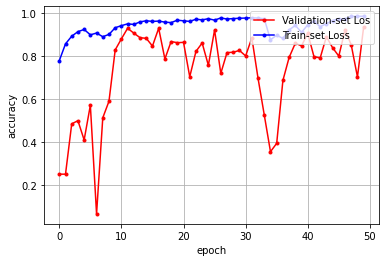

50/50 [==============================] - 0s 9ms/step - loss: 0.1821 - acc: 0.9450
[0.18212279677391052, 0.9449999928474426]


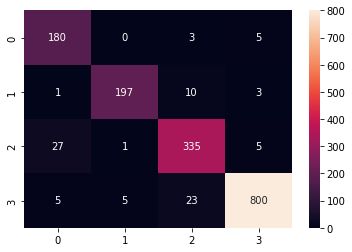

In [22]:
res_y_vaccuracy = history_res.history['val_acc'] 
res_y_accuracy = history_res.history['acc']

visulization_by_epochs(res_y_vaccuracy, res_y_accuracy)

result = model_res.evaluate(x_test, y_test)
print(result)

#confusion matrix를 확인하고 싶었지만, 해당 값이 분류모델로 되어있는 것이 아닌 상대적 확률로써 존재
y_predict = model_res.predict(x_test)

draw_confusionmatrix(y_predict, y_test)

46   0.946093738079071


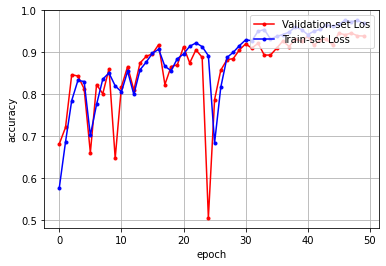

50/50 [==============================] - 0s 7ms/step - loss: 0.2111 - acc: 0.9456
[0.21110644936561584, 0.9456250071525574]


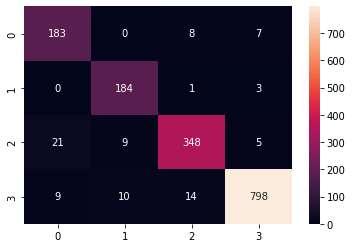

In [23]:
vgg_y_vaccuracy = history_vgg.history['val_acc'] 
vgg_y_accuracy = history_vgg.history['acc']

visulization_by_epochs(vgg_y_vaccuracy, vgg_y_accuracy)

result = model_vgg.evaluate(x_test, y_test)
print(result)

#confusion matrix를 확인하고 싶었지만, 해당 값이 분류모델로 되어있는 것이 아닌 상대적 확률로써 존재
y_predict = model_vgg.predict(x_test)

draw_confusionmatrix(y_predict, y_test)

35   0.930468738079071


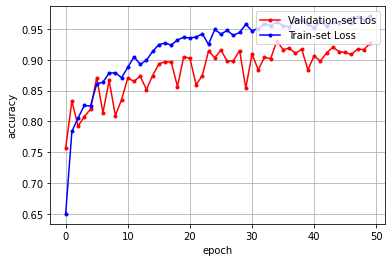

50/50 [==============================] - 0s 1ms/step - loss: 0.2143 - acc: 0.9231
[0.2142539918422699, 0.9231250286102295]


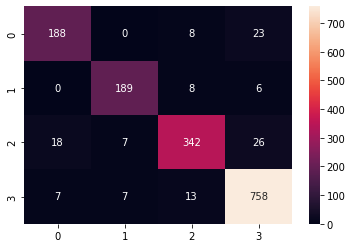

In [24]:
base_y_vaccuracy = history_base.history['val_acc'] 
base_y_accuracy = history_base.history['acc']

visulization_by_epochs(base_y_vaccuracy, base_y_accuracy)

result = model_base.evaluate(x_test, y_test)
print(result)

#confusion matrix를 확인하고 싶었지만, 해당 값이 분류모델로 되어있는 것이 아닌 상대적 확률로써 존재
y_predict = model_base.predict(x_test)

draw_confusionmatrix(y_predict, y_test)

##### epochs 조정
###### res = 50-->유지
###### vgg = 30
###### base = 70

In [25]:
history_vgg = model_vgg.fit(x_train, y_train, epochs=30, validation_data=(x_val, y_val))

Epoch 1/30
160/160 [==============================] - 5s 29ms/step - loss: 0.1542 - acc: 0.9566 - val_loss: 0.2397 - val_acc: 0.9195
Epoch 2/30
160/160 [==============================] - 5s 29ms/step - loss: 0.1286 - acc: 0.9545 - val_loss: 0.2316 - val_acc: 0.9367
Epoch 3/30
160/160 [==============================] - 5s 29ms/step - loss: 0.0964 - acc: 0.9662 - val_loss: 0.3187 - val_acc: 0.9273
Epoch 4/30
160/160 [==============================] - 5s 29ms/step - loss: 0.0778 - acc: 0.9748 - val_loss: 0.2120 - val_acc: 0.9391
Epoch 5/30
160/160 [==============================] - 5s 29ms/step - loss: 0.0951 - acc: 0.9676 - val_loss: 0.3141 - val_acc: 0.9078
Epoch 6/30
160/160 [==============================] - 5s 29ms/step - loss: 0.1221 - acc: 0.9596 - val_loss: 0.2052 - val_acc: 0.9367
Epoch 7/30
160/160 [==============================] - 5s 29ms/step - loss: 0.0785 - acc: 0.9744 - val_loss: 0.1949 - val_acc: 0.9352
Epoch 8/30
160/160 [==============================] - 5s 29ms/step - 

In [26]:
history_base = model_base.fit(x_train, y_train, epochs=70, validation_data=(x_val, y_val))

Epoch 1/70
160/160 [==============================] - 0s 3ms/step - loss: 0.0672 - acc: 0.9744 - val_loss: 0.3257 - val_acc: 0.8953
Epoch 2/70
160/160 [==============================] - 0s 2ms/step - loss: 0.0893 - acc: 0.9633 - val_loss: 0.2866 - val_acc: 0.9281
Epoch 3/70
160/160 [==============================] - 0s 2ms/step - loss: 0.0937 - acc: 0.9672 - val_loss: 0.2675 - val_acc: 0.9203
Epoch 4/70
160/160 [==============================] - 0s 2ms/step - loss: 0.0884 - acc: 0.9670 - val_loss: 0.2138 - val_acc: 0.9352
Epoch 5/70
160/160 [==============================] - 0s 2ms/step - loss: 0.0848 - acc: 0.9678 - val_loss: 0.2211 - val_acc: 0.9242
Epoch 6/70
160/160 [==============================] - 0s 2ms/step - loss: 0.0835 - acc: 0.9678 - val_loss: 0.2862 - val_acc: 0.9242
Epoch 7/70
160/160 [==============================] - 0s 2ms/step - loss: 0.0678 - acc: 0.9746 - val_loss: 0.3621 - val_acc: 0.9078
Epoch 8/70
160/160 [==============================] - 0s 2ms/step - loss: 0.

22   0.953906238079071


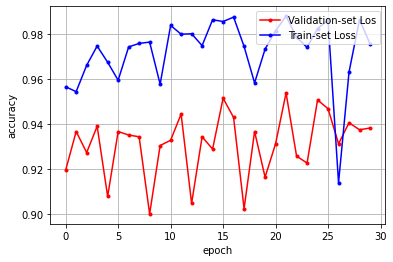

50/50 [==============================] - 0s 7ms/step - loss: 0.1817 - acc: 0.9419
[0.18174859881401062, 0.9418749809265137]


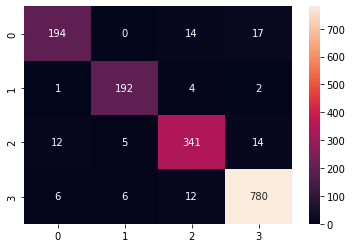

In [27]:
vgg_y_vaccuracy = history_vgg.history['val_acc'] 
vgg_y_accuracy = history_vgg.history['acc']

visulization_by_epochs(vgg_y_vaccuracy, vgg_y_accuracy)

result = model_vgg.evaluate(x_test, y_test)
print(result)

#confusion matrix를 확인하고 싶었지만, 해당 값이 분류모델로 되어있는 것이 아닌 상대적 확률로써 존재
y_predict = model_vgg.predict(x_test)

draw_confusionmatrix(y_predict, y_test)

58   0.9429687261581421


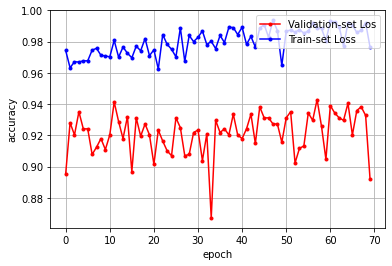

50/50 [==============================] - 0s 1ms/step - loss: 0.4465 - acc: 0.9087
[0.4465373158454895, 0.9087499976158142]


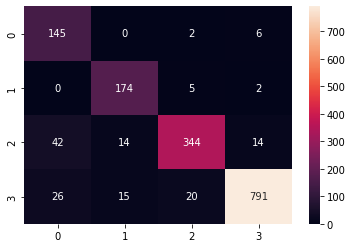

In [28]:
base_y_vaccuracy = history_base.history['val_acc'] 
base_y_accuracy = history_base.history['acc']

visulization_by_epochs(base_y_vaccuracy, base_y_accuracy)

result = model_base.evaluate(x_test, y_test)
print(result)

#confusion matrix를 확인하고 싶었지만, 해당 값이 분류모델로 되어있는 것이 아닌 상대적 확률로써 존재
y_predict = model_base.predict(x_test)

draw_confusionmatrix(y_predict, y_test)

### make Ensemble for Peseudo Labeling Voting 방식

##### Max Value in Whole Model 전체 모델에서 가장 높은 값으로 결정

In [29]:
res = model_res.predict(total_add_x)
vgg = model_vgg.predict(total_add_x)
base = model_base.predict(total_add_x)

In [30]:
def get_best_array(a):
    best_y = np.where(a == max(a))
    new_array = np.array([0, 0, 0, 0])
    new_array[best_y] = 1
    return new_array

Barren Land: 21.1%
Trees: 23.8%
Grassland: 27.1%
Other: 28.1%


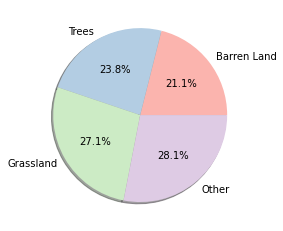

array([0.21065 , 0.2375  , 0.271175, 0.280675])

In [31]:
total_add_y = []
for i in range(len(total_add_x)):
    maxes = [max(res[i]), max(vgg[i]), max(base[i])]

    max_model_num = maxes.index(max(maxes))
    if max_model_num == 0:
        y = get_best_array(res[i])
    elif max_model_num == 1:
        y = get_best_array(vgg[i])
    else:
        y = get_best_array(base[i])
        
    total_add_y.append(y)
    
total_add_y = np.array(total_add_y)
Data_visualization(total_add_y)

Barren Land: 21.1%
Trees: 23.8%
Grassland: 27.1%
Other: 28.1%


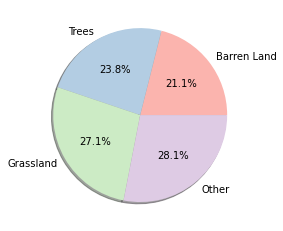

array([0.21065 , 0.2375  , 0.271175, 0.280675])

In [32]:
total_train_add_x = np.concatenate((total_train_x, total_add_x), axis = 0)
total_train_add_y = np.concatenate((total_train_y, total_add_y), axis = 0)

Data_visualization(total_add_y)

### Create Ensemble Model

##### model_res
##### model_vgg
##### model_base
##### 를 가지고 있음

In [33]:
x_train, x_test, y_train, y_test = train_test_split(total_train_add_x, total_train_add_y, test_size = 0.2)

In [34]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)

In [35]:
history_res = model_res.fit(x_train, y_train, epochs=30, validation_data=(x_val, y_val))

Epoch 1/30
960/960 [==============================] - 35s 36ms/step - loss: 0.2436 - acc: 0.9196 - val_loss: 0.1956 - val_acc: 0.9177
Epoch 2/30
960/960 [==============================] - 34s 36ms/step - loss: 0.2095 - acc: 0.9250 - val_loss: 0.3077 - val_acc: 0.8957
Epoch 3/30
960/960 [==============================] - 34s 36ms/step - loss: 0.1987 - acc: 0.9291 - val_loss: 0.2096 - val_acc: 0.9271
Epoch 4/30
960/960 [==============================] - 34s 36ms/step - loss: 0.1831 - acc: 0.9329 - val_loss: 0.8091 - val_acc: 0.7581
Epoch 5/30
960/960 [==============================] - 34s 36ms/step - loss: 0.1596 - acc: 0.9428 - val_loss: 0.2515 - val_acc: 0.8969
Epoch 6/30
960/960 [==============================] - 34s 36ms/step - loss: 0.1690 - acc: 0.9382 - val_loss: 0.1838 - val_acc: 0.9357
Epoch 7/30
960/960 [==============================] - 34s 36ms/step - loss: 0.1488 - acc: 0.9455 - val_loss: 0.1688 - val_acc: 0.9391
Epoch 8/30
960/960 [==============================] - 34s 36ms

In [36]:
history_vgg = model_vgg.fit(x_train, y_train, epochs=30, validation_data=(x_val, y_val))

Epoch 1/30
960/960 [==============================] - 27s 29ms/step - loss: 0.1968 - acc: 0.9294 - val_loss: 0.1795 - val_acc: 0.9368
Epoch 2/30
960/960 [==============================] - 27s 29ms/step - loss: 0.1726 - acc: 0.9385 - val_loss: 0.1730 - val_acc: 0.9375
Epoch 3/30
960/960 [==============================] - 27s 29ms/step - loss: 0.1404 - acc: 0.9490 - val_loss: 0.1480 - val_acc: 0.9492
Epoch 4/30
960/960 [==============================] - 27s 29ms/step - loss: 0.1394 - acc: 0.9510 - val_loss: 0.1826 - val_acc: 0.9422
Epoch 5/30
960/960 [==============================] - 27s 29ms/step - loss: 0.1324 - acc: 0.9537 - val_loss: 0.1553 - val_acc: 0.9451
Epoch 6/30
960/960 [==============================] - 27s 29ms/step - loss: 0.1128 - acc: 0.9602 - val_loss: 0.1799 - val_acc: 0.9448
Epoch 7/30
960/960 [==============================] - 27s 29ms/step - loss: 0.1355 - acc: 0.9558 - val_loss: 0.2127 - val_acc: 0.9322
Epoch 8/30
960/960 [==============================] - 27s 29ms

In [37]:
history_base = model_base.fit(x_train, y_train, epochs=30, validation_data=(x_val, y_val))

Epoch 1/30
960/960 [==============================] - 2s 2ms/step - loss: 0.2162 - acc: 0.9248 - val_loss: 0.1592 - val_acc: 0.9387
Epoch 2/30
960/960 [==============================] - 2s 2ms/step - loss: 0.1599 - acc: 0.9396 - val_loss: 0.1558 - val_acc: 0.9419
Epoch 3/30
960/960 [==============================] - 2s 2ms/step - loss: 0.1402 - acc: 0.9452 - val_loss: 0.1625 - val_acc: 0.9391
Epoch 4/30
960/960 [==============================] - 2s 2ms/step - loss: 0.1300 - acc: 0.9509 - val_loss: 0.1276 - val_acc: 0.9497
Epoch 5/30
960/960 [==============================] - 2s 2ms/step - loss: 0.1258 - acc: 0.9515 - val_loss: 0.1538 - val_acc: 0.9413
Epoch 6/30
960/960 [==============================] - 2s 2ms/step - loss: 0.1136 - acc: 0.9567 - val_loss: 0.1508 - val_acc: 0.9460
Epoch 7/30
960/960 [==============================] - 2s 2ms/step - loss: 0.1085 - acc: 0.9580 - val_loss: 0.1376 - val_acc: 0.9488
Epoch 8/30
960/960 [==============================] - 2s 2ms/step - loss: 0.

24   0.9446614384651184


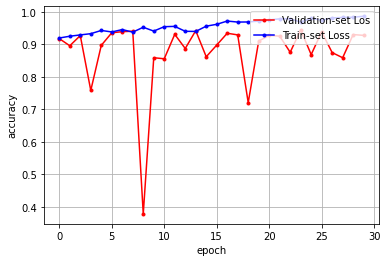

300/300 [==============================] - 3s 9ms/step - loss: 0.2534 - acc: 0.9248
[0.25340038537979126, 0.924791693687439]


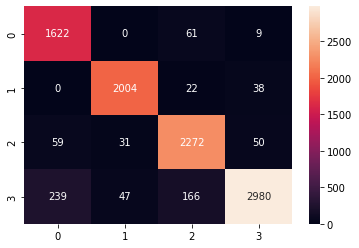

In [38]:
res_y_vaccuracy = history_res.history['val_acc'] 
res_y_accuracy = history_res.history['acc']

visulization_by_epochs(res_y_vaccuracy, res_y_accuracy)

result = model_res.evaluate(x_test, y_test)
print(result)

#confusion matrix를 확인하고 싶었지만, 해당 값이 분류모델로 되어있는 것이 아닌 상대적 확률로써 존재
y_predict = model_res.predict(x_test)

draw_confusionmatrix(y_predict, y_test)

11   0.9510416388511658


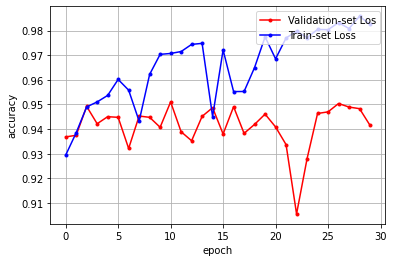

300/300 [==============================] - 2s 7ms/step - loss: 0.1906 - acc: 0.9438
[0.19055218994617462, 0.9437500238418579]


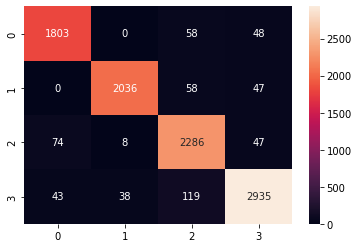

In [39]:
vgg_y_vaccuracy = history_vgg.history['val_acc'] 
vgg_y_accuracy = history_vgg.history['acc']

visulization_by_epochs(vgg_y_vaccuracy, vgg_y_accuracy)

result = model_vgg.evaluate(x_test, y_test)
print(result)

#confusion matrix를 확인하고 싶었지만, 해당 값이 분류모델로 되어있는 것이 아닌 상대적 확률로써 존재
y_predict = model_vgg.predict(x_test)

draw_confusionmatrix(y_predict, y_test)

13   0.9540364742279053


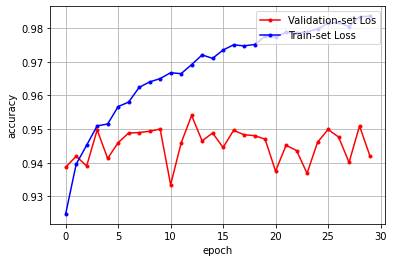

300/300 [==============================] - 0s 1ms/step - loss: 0.2452 - acc: 0.9418
[0.2452060431241989, 0.9417708516120911]


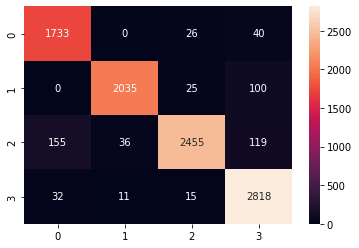

In [40]:
base_y_vaccuracy = history_base.history['val_acc'] 
base_y_accuracy = history_base.history['acc']

visulization_by_epochs(base_y_vaccuracy, base_y_accuracy)

result = model_base.evaluate(x_test, y_test)
print(result)

#confusion matrix를 확인하고 싶었지만, 해당 값이 분류모델로 되어있는 것이 아닌 상대적 확률로써 존재
y_predict = model_base.predict(x_test)

draw_confusionmatrix(y_predict, y_test)

### Bagging

### 보편적으로 확률이 좋은 VGG16을 설정

In [41]:
x_train, x_test, y_train, y_test = train_test_split(total_train_add_x, total_train_add_y, test_size = 0.2)

In [42]:
x_train_1, x_train_3, y_train_1, y_train_3 = train_test_split(total_train_add_x, total_train_add_y, test_size = 0.3)
x_train_1, x_train_2, y_train_1, y_train_2 = train_test_split(x_train_1, y_train_1, test_size = 0.5)

In [43]:
x_train_1, x_val_1, y_train_1, y_val_1 = train_test_split(x_train_1, y_train_1, test_size = 0.2)
x_train_2, x_val_2, y_train_2, y_val_2 = train_test_split(x_train_2, y_train_2, test_size = 0.2)
x_train_3, x_val_3, y_train_3, y_val_3 = train_test_split(x_train_3, y_train_3, test_size = 0.2)

In [44]:
history_vgg_1 = model_vgg.fit(x_train_1, y_train_1, epochs=30, validation_data=(x_val_1, y_val_1))

Epoch 1/30
420/420 [==============================] - 12s 29ms/step - loss: 0.1499 - acc: 0.9519 - val_loss: 0.2087 - val_acc: 0.9455
Epoch 2/30
420/420 [==============================] - 12s 29ms/step - loss: 0.0907 - acc: 0.9701 - val_loss: 0.1024 - val_acc: 0.9688
Epoch 3/30
420/420 [==============================] - 12s 29ms/step - loss: 0.0494 - acc: 0.9824 - val_loss: 0.1004 - val_acc: 0.9693
Epoch 4/30
420/420 [==============================] - 12s 29ms/step - loss: 0.0616 - acc: 0.9829 - val_loss: 0.1358 - val_acc: 0.9616
Epoch 5/30
420/420 [==============================] - 12s 29ms/step - loss: 0.0602 - acc: 0.9801 - val_loss: 0.1589 - val_acc: 0.9577
Epoch 6/30
420/420 [==============================] - 12s 29ms/step - loss: 0.2195 - acc: 0.9295 - val_loss: 0.2104 - val_acc: 0.9253
Epoch 7/30
420/420 [==============================] - 12s 29ms/step - loss: 0.0983 - acc: 0.9644 - val_loss: 0.1566 - val_acc: 0.9551
Epoch 8/30
420/420 [==============================] - 12s 29ms

In [45]:
model_vgg2 = model_vgg
history_vgg_2 = model_vgg2.fit(x_train_2, y_train_2, epochs=30, validation_data=(x_val_2, y_val_2))

Epoch 1/30
420/420 [==============================] - 12s 29ms/step - loss: 0.1423 - acc: 0.9504 - val_loss: 0.1624 - val_acc: 0.9423
Epoch 2/30
420/420 [==============================] - 12s 29ms/step - loss: 0.1041 - acc: 0.9624 - val_loss: 0.1544 - val_acc: 0.9488
Epoch 3/30
420/420 [==============================] - 12s 29ms/step - loss: 0.0825 - acc: 0.9708 - val_loss: 0.1250 - val_acc: 0.9565
Epoch 4/30
420/420 [==============================] - 12s 29ms/step - loss: 0.0642 - acc: 0.9774 - val_loss: 0.1437 - val_acc: 0.9533
Epoch 5/30
420/420 [==============================] - 12s 29ms/step - loss: 0.0555 - acc: 0.9802 - val_loss: 0.1681 - val_acc: 0.9533
Epoch 6/30
420/420 [==============================] - 12s 29ms/step - loss: 0.1120 - acc: 0.9668 - val_loss: 0.1476 - val_acc: 0.9527
Epoch 7/30
420/420 [==============================] - 12s 29ms/step - loss: 0.0499 - acc: 0.9824 - val_loss: 0.1741 - val_acc: 0.9533
Epoch 8/30
420/420 [==============================] - 12s 29ms

In [46]:
model_vgg3 = model_vgg
history_vgg_3 = model_vgg3.fit(x_train_3, y_train_3, epochs=30, validation_data=(x_val_3, y_val_3))

Epoch 1/30
360/360 [==============================] - 10s 29ms/step - loss: 0.1505 - acc: 0.9490 - val_loss: 0.1156 - val_acc: 0.9615
Epoch 2/30
360/360 [==============================] - 10s 29ms/step - loss: 0.1012 - acc: 0.9651 - val_loss: 0.1029 - val_acc: 0.9625
Epoch 3/30
360/360 [==============================] - 10s 29ms/step - loss: 0.0723 - acc: 0.9740 - val_loss: 0.0982 - val_acc: 0.9681
Epoch 4/30
360/360 [==============================] - 10s 29ms/step - loss: 0.0597 - acc: 0.9813 - val_loss: 0.0988 - val_acc: 0.9663
Epoch 5/30
360/360 [==============================] - 10s 29ms/step - loss: 0.0464 - acc: 0.9865 - val_loss: 0.1182 - val_acc: 0.9649
Epoch 6/30
360/360 [==============================] - 10s 29ms/step - loss: 0.0451 - acc: 0.9854 - val_loss: 0.1399 - val_acc: 0.9653
Epoch 7/30
360/360 [==============================] - 10s 29ms/step - loss: 0.2059 - acc: 0.9701 - val_loss: 0.2844 - val_acc: 0.9052
Epoch 8/30
360/360 [==============================] - 10s 29ms

In [47]:
model_vgg.save('./bagging/bagging_vgg1.h5')
model_vgg2.save('./bagging/bagging_vgg2.h5')
model_vgg3.save('./bagging/bagging_vgg3.h5')

### Voting

In [49]:
history_res = model_res.fit(x_train, y_train, epochs=30, validation_data=(x_val, y_val))

Epoch 1/30
1200/1200 [==============================] - 43s 36ms/step - loss: 0.1373 - acc: 0.9556 - val_loss: 1.9375 - val_acc: 0.7783
Epoch 2/30
1200/1200 [==============================] - 42s 35ms/step - loss: 0.1489 - acc: 0.9475 - val_loss: 0.2574 - val_acc: 0.9000
Epoch 3/30
1200/1200 [==============================] - 43s 36ms/step - loss: 0.1065 - acc: 0.9628 - val_loss: 0.2040 - val_acc: 0.9250
Epoch 4/30
1200/1200 [==============================] - 43s 35ms/step - loss: 0.0793 - acc: 0.9724 - val_loss: 0.1139 - val_acc: 0.9590
Epoch 5/30
1200/1200 [==============================] - 43s 35ms/step - loss: 0.0695 - acc: 0.9753 - val_loss: 0.1341 - val_acc: 0.9531
Epoch 6/30
1200/1200 [==============================] - 43s 35ms/step - loss: 0.0593 - acc: 0.9794 - val_loss: 0.0974 - val_acc: 0.9658
Epoch 7/30
1200/1200 [==============================] - 43s 36ms/step - loss: 0.0712 - acc: 0.9763 - val_loss: 0.1052 - val_acc: 0.9615
Epoch 8/30
1200/1200 [==========================

In [50]:
history_vgg = model_vgg.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val))

Epoch 1/50
1200/1200 [==============================] - 34s 28ms/step - loss: 0.2039 - acc: 0.9419 - val_loss: 0.1285 - val_acc: 0.9555
Epoch 2/50
1200/1200 [==============================] - 34s 28ms/step - loss: 0.0935 - acc: 0.9677 - val_loss: 0.0939 - val_acc: 0.9684
Epoch 3/50
1200/1200 [==============================] - 34s 28ms/step - loss: 0.0731 - acc: 0.9752 - val_loss: 0.1010 - val_acc: 0.9658
Epoch 4/50
1200/1200 [==============================] - 34s 28ms/step - loss: 0.0900 - acc: 0.9700 - val_loss: 0.0519 - val_acc: 0.9822
Epoch 5/50
1200/1200 [==============================] - 34s 28ms/step - loss: 0.0516 - acc: 0.9833 - val_loss: 0.0521 - val_acc: 0.9835
Epoch 6/50
1200/1200 [==============================] - 34s 28ms/step - loss: 0.0420 - acc: 0.9863 - val_loss: 0.0349 - val_acc: 0.9897
Epoch 7/50
1200/1200 [==============================] - 34s 28ms/step - loss: 0.0424 - acc: 0.9862 - val_loss: 0.0309 - val_acc: 0.9875
Epoch 8/50
1200/1200 [==========================

In [51]:
history_base = model_base.fit(x_train, y_train, epochs=30, validation_data=(x_val, y_val))

Epoch 1/30
1200/1200 [==============================] - 3s 3ms/step - loss: 0.1175 - acc: 0.9618 - val_loss: 0.1458 - val_acc: 0.9478
Epoch 2/30
1200/1200 [==============================] - 3s 3ms/step - loss: 0.0887 - acc: 0.9697 - val_loss: 0.1221 - val_acc: 0.9574
Epoch 3/30
1200/1200 [==============================] - 3s 3ms/step - loss: 0.0731 - acc: 0.9745 - val_loss: 0.0838 - val_acc: 0.9724
Epoch 4/30
1200/1200 [==============================] - 3s 3ms/step - loss: 0.0743 - acc: 0.9730 - val_loss: 0.0905 - val_acc: 0.9697
Epoch 5/30
1200/1200 [==============================] - 3s 2ms/step - loss: 0.0688 - acc: 0.9756 - val_loss: 0.0874 - val_acc: 0.9708
Epoch 6/30
1200/1200 [==============================] - 3s 2ms/step - loss: 0.0652 - acc: 0.9766 - val_loss: 0.0849 - val_acc: 0.9717
Epoch 7/30
1200/1200 [==============================] - 3s 2ms/step - loss: 0.0621 - acc: 0.9770 - val_loss: 0.0705 - val_acc: 0.9757
Epoch 8/30
1200/1200 [==============================] - 3s 2ms

In [52]:
img_shape = (x_squeeze_img_v1_train[1], x_squeeze_img_v1_train[2], x_squeeze_img_v1_train[3])
model_res2 = models.Sequential()
# For training from scratch change kernel_initializer to e.g.'VarianceScaling'
model_res2.add(layers.ZeroPadding2D(padding = (2,2), input_shape = (28, 28, 3)))
model_res2.add(ResNet50_MODEL)
model_res2.add(layers.Dropout(0.25))
model_res2.add(layers.Flatten())
model_res2.add(layers.Dense(256, activation='relu'))
model_res2.add(layers.Dense(128, activation='relu'))
model_res2.add(layers.Dense(4, activation='softmax'))

model_res2.compile(optimizer='Adam',
                     loss='categorical_crossentropy',
                     metrics=['acc'])

model_res2.summary()
history_res_2 = model_res2.fit(x_train, y_train, epochs=30, validation_data=(x_val, y_val))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_2 (ZeroPaddin (None, 32, 32, 3)         0         
_________________________________________________________________
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1, 2048)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_10 (Dense)             (None, 4)                

In [53]:
img_shape = (X_train_img[1], X_train_img[2], X_train_img[3])
model_vgg2 = models.Sequential()
# For training from scratch change kernel_initializer to e.g.'VarianceScaling'
model_vgg2.add(layers.ZeroPadding2D(padding = (2,2), input_shape = (28, 28 ,3)))
model_vgg2.add(VGG16_model)
model_vgg2.add(layers.Dropout(0.25))
model_vgg2.add(layers.Flatten())
model_vgg2.add(layers.Dense(256, activation='relu'))
model_vgg2.add(layers.Dense(128, activation='relu'))
model_vgg2.add(layers.Dense(4, activation='softmax'))

model_vgg2.compile(optimizer='Adam',
                     loss='categorical_crossentropy',
                     metrics=['acc'])

model_vgg2.summary()
history_vgg_2 = model_vgg2.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_3 (ZeroPaddin (None, 32, 32, 3)         0         
_________________________________________________________________
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 1, 512)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_12 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_13 (Dense)             (None, 4)                

In [54]:
model_base2=models.Sequential()
model_base2.add( layers.Conv2D(32,(5,5),activation='relu',input_shape=(28,28,3)))
model_base2.add(layers.MaxPool2D((2,2)))
model_base2.add(layers.Conv2D(64,(2,2),activation='relu',padding='same'))
model_base2.add(layers.MaxPooling2D((2, 2)))
model_base2.add(layers.Conv2D(128,(2,2),activation='relu',padding='same'))
model_base2.add(layers.MaxPooling2D((2, 2)))
model_base2.add(layers.Dropout(0.25))
model_base2.add(layers.Flatten())

model_base2.add(layers.Dense(128, activation='relu'))
model_base2.add(layers.Dense(64, activation='relu'))
model_base2.add( layers.Dense(4, activation='softmax'))
model_base2.summary()
model_base2.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['acc'])
history_base_2 = model_base2.fit(x_train, y_train, epochs=30, validation_data=(x_val, y_val))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 24, 24, 32)        2432      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 128)         32896     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 3, 3, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 3, 3, 128)        

In [55]:
model_res.save('./voting/voting_model_res.h5')
model_vgg.save('./voting/voting_model_vgg.h5')
model_base.save('./voting/voting_model_base.h5')
model_res2.save('./voting/voting_model_res2.h5')
model_vgg2.save('./voting/voting_model_vgg2.h5')
model_base2.save('./voting/voting_model_base2.h5')